In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skhep.visual import MplPlotter as skh_plt
import os
import tdrstyle as tdr

ROOT.gStyle.SetOptStat(0)
tdr.setTDRStyle()

Welcome to JupyROOT 6.16/00


In [66]:
def Energy_loss(jet_pt, L):
    random = ROOT.TRandom3()
    
    # C = 0.055 # function3 (a,b)=(1,1)
    # C = 0.0055 # function2 (a,b)=(1,2)
    # dE_avg = C*pow(jet_pt,1)*pow(L,2)
    
    C1 = 0.03
    C2 = 0.003
    N = random.Exp(L/14.)

    dE_avg = C1*pow(jet_pt,1)*pow(L,1) + (int(N)+1)*C2*pow(jet_pt,2)
    dE = random.PoissonD(dE_avg)
    
    return dE

print (120./130.,Energy_loss(120,5)/Energy_loss(130,9))

0.9230769230769231 0.7204301075268817


In [30]:
def deltaPhi(phi1, phi2):
    dPhi = phi1 - phi2
    if dPhi > ROOT.TMath.Pi():
        dPhi -= 2.*ROOT.TMath.Pi()
    if dPhi < -ROOT.TMath.Pi():
        dPhi += 2.*ROOT.TMath.Pi()

    return dPhi


def deltaR(eta1, phi1, eta2, phi2):
    dEta = eta1 - eta2
    dPhi = deltaPhi(phi1, phi2)
    return ROOT.TMath.Sqrt(dEta*dEta+dPhi*dPhi)


def deltaEta(eta1, eta2):
    return eta1 - eta2

In [4]:
f_hM = ROOT.TFile('../GlauberMC/plots/histogram-R1R2.root','READ')
f_hM.cd()
hM_R1R2 = f_hM.Get('hM_R1R2')
hM_R1R2.SetDirectory(0)
f_hM.Close()

In [67]:
f = ROOT.TFile('./data/dijet_events_v2.root','READ')
tree = ROOT.gROOT.FindObject("EventTree")

list_pt_bin = [100,126,158,200]
list_hM_xJ = []
list_hM_xJ_dE = []
list_hM_AJ = []
list_hM_AJ_dE = []

ATLAS_bin = np.array([0.0,0.04,0.08,0.11,0.14,0.17,0.2,0.23,0.26,0.29,
             0.33597-0.01842,
             0.3769-0.02204,
             0.4231-0.02435,
             0.47459-0.02757,
             0.53267-0.03079,
             0.59736-0.03404,
             0.66997-0.03643,
             0.75182-0.04148,
             0.8429-0.04698,
             0.94587-0.05339,1.0], dtype='float64')

for ibin in range(len(list_pt_bin)):
    list_hM_xJ.append(ROOT.TH1F('hM_xJ','hM_xJ',len(ATLAS_bin)-1, ATLAS_bin))
    list_hM_xJ_dE.append(ROOT.TH1F('hM_xJ_dE','hM_xJ_dE',len(ATLAS_bin)-1, ATLAS_bin))
    list_hM_AJ.append(ROOT.TH1F('hM_AJ','hM_AJ',len(ATLAS_bin)-1, ATLAS_bin))
    list_hM_AJ_dE.append(ROOT.TH1F('hM_AJ_dE','hM_AJ_dE',len(ATLAS_bin)-1, ATLAS_bin))

    
hM_jetpt = ROOT.TH2F('hM_jetpt','hM_jetpt',100,0,500,100,0,500)
hM_dPhi = ROOT.TH1F('hM_dPhi','hM_dPhi',50,0,ROOT.TMath.Pi())

nEntries =  tree.GetEntries()
for iEntry in range(0,nEntries):
    tree.GetEntry(iEntry)
    
    if len(tree.pT) < 2:
        continue
        
    pT_jet1 = -1.
    pT_jet2 = -1.
    if tree.pT[0] > tree.pT[1]:
        pT_jet1 = tree.pT[0]
        pT_jet2 = tree.pT[1]
    else:
        pT_jet1 = tree.pT[1]
        pT_jet2 = tree.pT[0]
    
    
    hM_jetpt.Fill(tree.pT[0],tree.pT[1])
    hM_dPhi.Fill(abs(deltaPhi(tree.phi[0],tree.phi[1])))
    
    # Jet selection, following ATLAS analysis arXiv:1706.09363
    if pT_jet1 < 25. or pT_jet2 < 25.:
        continue
        
    if abs(tree.eta[0]) > 2.1 or abs(tree.eta[1]) > 2.1:
        continue
        
    if abs(deltaPhi(tree.phi[0],tree.phi[1])) < (7.*ROOT.TMath.Pi())/8.:
        continue
    
    if pT_jet1 < 100.:
        continue
        
    
    xJ = pT_jet2/pT_jet1
    AJ = (pT_jet1-pT_jet2)/(pT_jet1+pT_jet2)
    
    L1 = ROOT.Double(0.0)
    L2 = ROOT.Double(0.0)
    hM_R1R2.GetRandom2(L1,L2)
    
    dE_jet1 = Energy_loss(pT_jet1, L1)
    dE_jet2 = Energy_loss(pT_jet2, L2)
    
    pT_jet1_dE = pT_jet1 - dE_jet1
    pT_jet2_dE = pT_jet2 - dE_jet2
    if pT_jet1_dE < pT_jet2_dE:
        tmp = pT_jet2_dE
        pT_jet2_dE = pT_jet1_dE
        pT_jet1_dE = tmp
    
    xJ_dE = pT_jet2_dE/pT_jet1_dE
    AJ_dE = (pT_jet1_dE-pT_jet2_dE)/(pT_jet1_dE+pT_jet2_dE)
    
    if iEntry < 100:
        print (xJ,xJ_dE)
        
    if pT_jet1 > 100. and pT_jet1 < 126.:
        list_hM_xJ[0].Fill(xJ)
        list_hM_xJ_dE[0].Fill(xJ_dE)
        list_hM_AJ[0].Fill(AJ)
        list_hM_AJ_dE[0].Fill(AJ_dE)
    elif pT_jet1 > 126. and pT_jet1 < 158.:
        list_hM_xJ[1].Fill(xJ)
        list_hM_xJ_dE[1].Fill(xJ_dE)
        list_hM_AJ[1].Fill(AJ)
        list_hM_AJ_dE[1].Fill(AJ_dE)
    elif pT_jet1 > 158. and pT_jet1 < 200.:
        list_hM_xJ[2].Fill(xJ)
        list_hM_xJ_dE[2].Fill(xJ_dE)
        list_hM_AJ[2].Fill(AJ)
        list_hM_AJ_dE[2].Fill(AJ_dE)
    elif pT_jet1 > 200.:
        list_hM_xJ[3].Fill(xJ)
        list_hM_xJ_dE[3].Fill(xJ_dE)
        list_hM_AJ[3].Fill(AJ)
        list_hM_AJ_dE[3].Fill(AJ_dE)
    else:
        continue

0.7014292058538296 0.7607791186816408


Warning in <TFile::Append>: Replacing existing TH1: hM_xJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_xJ_dE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hM_AJ_dE (Potential 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0
Info in <TCanvas::Print>: png file ./plots/JetpT-distribution-v2.png has been created
Info in <TCanvas::Print>: pdf file ./plots/JetpT-distribution-v2.pdf has been created


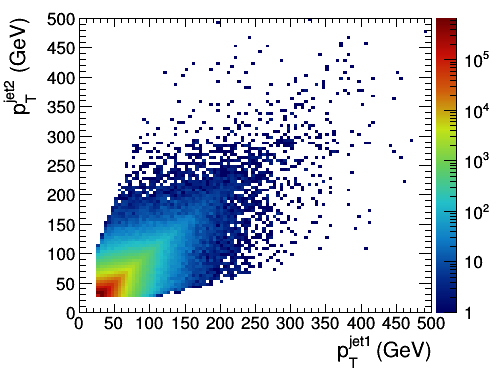

In [91]:
c0 = ROOT.TCanvas('c0', 'c0', 500, 400)
ROOT.gStyle.SetPalette(55)
c0.cd()
# c0.SetLogx()
# c0.SetLogy()
c0.SetLogz()
ROOT.gPad.SetRightMargin(0.13)
ROOT.gPad.SetBottomMargin(0.16)
hM_jetpt.GetXaxis().SetTitle('p_{T}^{jet1} (GeV)')
hM_jetpt.GetYaxis().SetTitle('p_{T}^{jet2} (GeV)')
hM_jetpt.GetXaxis().SetTitleOffset(1.1)
hM_jetpt.SetContour(2000)
hM_jetpt.Draw('colz')

ROOT.gPad.Update()
palette = hM_jetpt.GetListOfFunctions().FindObject('palette')
palette.SetX1NDC(0.88)
palette.SetX2NDC(0.92)
palette.SetY1NDC(0.16)
palette.SetY2NDC(0.95)
ROOT.gPad.Modified()
ROOT.gPad.Update()

c0.Draw()
c0.SaveAs('./plots/JetpT-distribution-v2.png')
c0.SaveAs('./plots/JetpT-distribution-v2.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file ./plots/DijetDeltaPhi-distribution-v2.png has been created
Info in <TCanvas::Print>: pdf file ./plots/DijetDeltaPhi-distribution-v2.pdf has been created


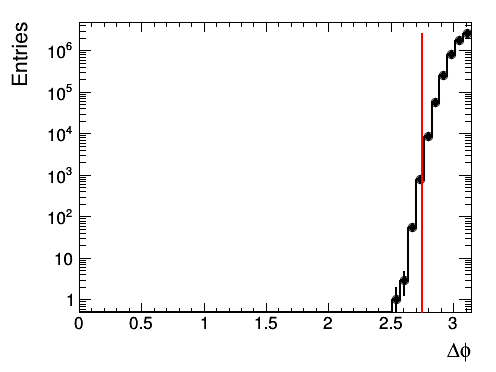

In [89]:
c1 = ROOT.TCanvas('c1', 'c1', 500, 400)
c1.cd()
c1.SetLogy()
ROOT.gPad.SetRightMargin(0.05)
ROOT.gPad.SetBottomMargin(0.16)
ROOT.gPad.SetTopMargin(0.06)
hM_dPhi.GetXaxis().SetTitle('#Delta#phi')
hM_dPhi.GetYaxis().SetTitle('Entries')
hM_dPhi.GetXaxis().SetTitleOffset(1.1)
hM_dPhi.SetLineWidth(2)
hM_dPhi.Draw('histe')

l = ROOT.TLine(7.*ROOT.TMath.Pi()/8.,c1.GetUymin(),7.*ROOT.TMath.Pi()/8.,hM_dPhi.GetMaximum())
l.SetLineColor(2)
l.SetLineWidth(2)
l.Draw('same')

c1.Draw()
c1.SaveAs('./plots/DijetDeltaPhi-distribution-v2.png')
c1.SaveAs('./plots/DijetDeltaPhi-distribution-v2.pdf')

In [21]:
list_ATLAS_PbPb_data_Stat = ['ATLAS-PbPb-100to126GeV-Stat.csv',
                             'ATLAS-PbPb-126to158GeV-Stat.csv',
                             'ATLAS-PbPb-158to200GeV-Stat.csv',
                             'ATLAS-PbPb-200toinvGeV-Stat.csv']

list_ATLAS_PbPb_data_Syst = ['ATLAS-PbPb-100to126GeV-Syst.csv',
                             'ATLAS-PbPb-126to158GeV-Syst.csv',
                             'ATLAS-PbPb-158to200GeV-Syst.csv',
                             'ATLAS-PbPb-200toinvGeV-Syst.csv']

list_ATLAS_pp_data_Stat = ['ATLAS-pp-100to126GeV-Stat.csv',
                             'ATLAS-pp-126to158GeV-Stat.csv',
                             'ATLAS-pp-158to200GeV-Stat.csv',
                             'ATLAS-pp-200toinvGeV-Stat.csv']

list_ATLAS_pp_data_Syst = ['ATLAS-pp-100to126GeV-Syst.csv',
                             'ATLAS-pp-126to158GeV-Syst.csv',
                             'ATLAS-pp-158to200GeV-Syst.csv',
                             'ATLAS-pp-200toinvGeV-Syst.csv']

list_ATLAS_PbPb_gr_Stat = []
list_ATLAS_PbPb_gr_Syst = []
list_ATLAS_pp_gr_Stat = []
list_ATLAS_pp_gr_Syst = []

list_ATLAS_Norm_PbPb = []

for ibin in range(len(list_ATLAS_PbPb_data_Stat)):
    list_ATLAS_PbPb_gr_Stat.append(ROOT.TGraphAsymmErrors('./data/ATLAS-arXiv170609363-Fig9/'+list_ATLAS_PbPb_data_Stat[ibin],
                                                          '%lf,%lf,%lf,%lf,%lf,%lf'))
    list_ATLAS_PbPb_gr_Syst.append(ROOT.TGraphAsymmErrors('./data/ATLAS-arXiv170609363-Fig9/'+list_ATLAS_PbPb_data_Syst[ibin],
                                                          '%lf,%lf,%lf,%lf,%lf,%lf'))
    list_ATLAS_pp_gr_Stat.append(ROOT.TGraphAsymmErrors('./data/ATLAS-arXiv170609363-Fig9/'+list_ATLAS_pp_data_Stat[ibin],
                                                          '%lf,%lf,%lf,%lf,%lf,%lf'))
    list_ATLAS_pp_gr_Syst.append(ROOT.TGraphAsymmErrors('./data/ATLAS-arXiv170609363-Fig9/'+list_ATLAS_pp_data_Syst[ibin],
                                                          '%lf,%lf,%lf,%lf,%lf,%lf'))
    
    norm = 0.
    for i in range(len(list_yval)):
        norm = norm + list_ATLAS_PbPb_gr_Stat[ibin].GetY()[i]
    
    list_ATLAS_Norm_PbPb.append(norm)
    

13.64153
13.51679
13.56523
12.709029999999998


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ./plots/xJ-inclusive-pp-EnergyLoss-function7-v2.png has been created
Info in <TCanvas::Print>: pdf file ./plots/xJ-inclusive-pp-EnergyLoss-function7-v2.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cl
Info in <TCanvas::Print>: png file ./plots/legend-xJ-inclusive-pp-EnergyLoss.png has been created
Info in <TCanvas::Print>: pdf file ./plots/legend-xJ-inclusive-pp-EnergyLoss.pdf has been created


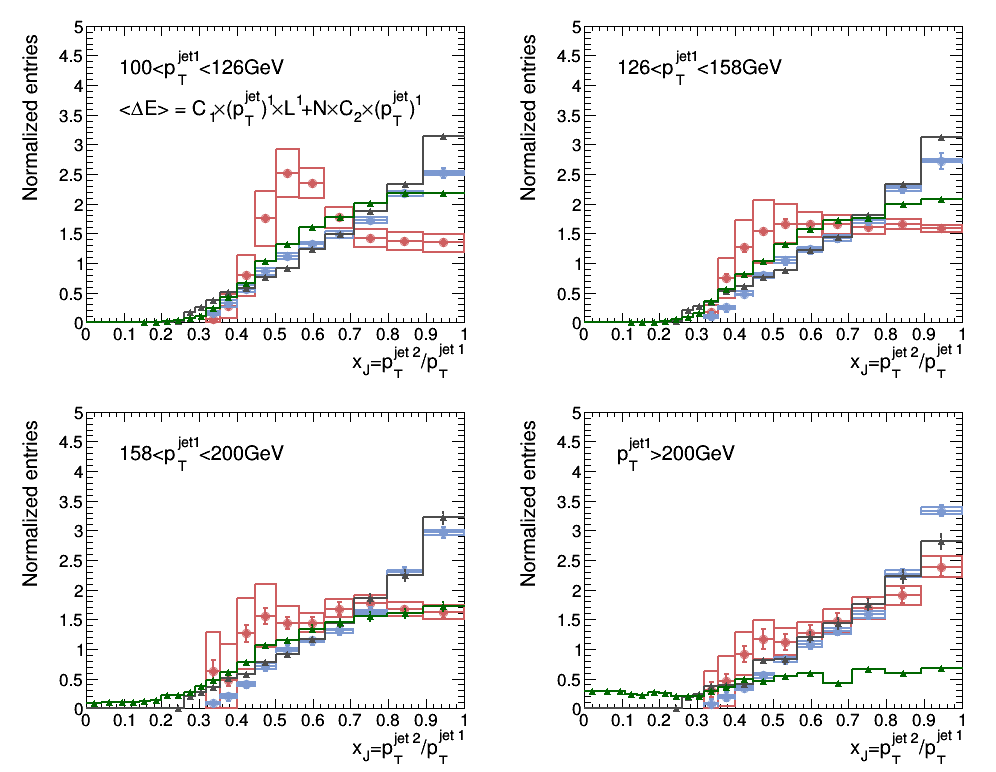

In [68]:
for ibin in range(len(list_pt_bin)):
    list_hM_xJ[ibin].Scale(list_ATLAS_Norm_PbPb[ibin]/list_hM_xJ[ibin].Integral(-1,-1))
    list_hM_xJ_dE[ibin].Scale(list_ATLAS_Norm_PbPb[ibin]/list_hM_xJ_dE[ibin].Integral(-1,-1))
    
    
list_extratext = ['100<p_{T}^{jet1}<126GeV','126<p_{T}^{jet1}<158GeV','158<p_{T}^{jet1}<200GeV','p_{T}^{jet1}>200GeV']

c = ROOT.TCanvas('c', 'c', 1000, 800)
c.Divide(2,2)

for icd in range(len(list_pt_bin)):
    c.cd(icd+1)
    ROOT.gPad.SetRightMargin(0.05)
    ROOT.gPad.SetBottomMargin(0.15)
    list_hM_xJ[icd].SetLineWidth(2)
    list_hM_xJ[icd].SetMarkerStyle(22)
    list_hM_xJ[icd].SetLineColor(12)
    list_hM_xJ[icd].SetMarkerColor(12)
    list_hM_xJ[icd].GetXaxis().SetTitle('x_{J}=p_{T}^{jet 2}/p_{T}^{jet 1}')
    list_hM_xJ[icd].GetYaxis().SetTitle('Normalized entries')
    list_hM_xJ[icd].GetXaxis().SetTitleOffset(1.1)
    list_hM_xJ[icd].GetYaxis().SetRangeUser(0,5)
    list_hM_xJ[icd].Draw('histeX0')

    list_hM_xJ_dE[icd].SetLineWidth(2)
    list_hM_xJ_dE[icd].SetMarkerStyle(22)
    list_hM_xJ_dE[icd].SetLineColor(ROOT.kGreen+3)
    list_hM_xJ_dE[icd].SetMarkerColor(ROOT.kGreen+3)
    list_hM_xJ_dE[icd].Draw('histeX0same')

#     list_ATLAS_gr_Syst[icd].GetXaxis().SetLimits(0,1)
#     list_ATLAS_gr_Syst[icd].GetYaxis().SetRangeUser(0,5)
    list_ATLAS_PbPb_gr_Syst[icd].SetMarkerColor(46)
    list_ATLAS_PbPb_gr_Syst[icd].SetFillColor(ROOT.kRed-9)
    list_ATLAS_PbPb_gr_Syst[icd].SetLineColor(46)
    list_ATLAS_PbPb_gr_Syst[icd].SetLineWidth(2)
    list_ATLAS_PbPb_gr_Syst[icd].SetMarkerStyle(20)
    list_ATLAS_PbPb_gr_Syst[icd].SetFillStyle(0)
    list_ATLAS_PbPb_gr_Syst[icd].Draw('E2same')
    
    list_ATLAS_PbPb_gr_Stat[icd].SetMarkerColor(46)
    list_ATLAS_PbPb_gr_Stat[icd].SetLineColor(46)
    list_ATLAS_PbPb_gr_Stat[icd].SetLineWidth(2)
    list_ATLAS_PbPb_gr_Stat[icd].SetMarkerStyle(20)
    list_ATLAS_PbPb_gr_Stat[icd].Draw('Psame')
    
    list_ATLAS_pp_gr_Syst[icd].SetMarkerColor(38)
    list_ATLAS_pp_gr_Syst[icd].SetFillColor(ROOT.kBlue-9)
    list_ATLAS_pp_gr_Syst[icd].SetLineColor(38)
    list_ATLAS_pp_gr_Syst[icd].SetLineWidth(2)
    list_ATLAS_pp_gr_Syst[icd].SetMarkerStyle(20)
    list_ATLAS_pp_gr_Syst[icd].SetFillStyle(0)
    list_ATLAS_pp_gr_Syst[icd].Draw('E2same')
    
    list_ATLAS_pp_gr_Stat[icd].SetMarkerColor(38)
    list_ATLAS_pp_gr_Stat[icd].SetLineColor(38)
    list_ATLAS_pp_gr_Stat[icd].SetLineWidth(2)
    list_ATLAS_pp_gr_Stat[icd].SetMarkerStyle(20)
    list_ATLAS_pp_gr_Stat[icd].Draw('Psame')
    
    list_hM_xJ[icd].Draw('histeX0same')
    list_hM_xJ_dE[icd].Draw('histeX0same')
    
    if icd == 0:
        latex = ROOT.TLatex()
        latex.SetNDC()
        latex.SetTextFont(42)
        latex.SetTextSize(0.06)
        # latex.DrawLatex(0.23, 0.71, '<#DeltaE> = f(p_{T}^{jet},L) = C#times(p_{T}^{jet})^{1}#timesL^{2}')
        latex.DrawLatex(0.23, 0.71, '<#DeltaE> = C_{1}#times(p_{T}^{jet})^{1}#timesL^{1}+N#timesC_{2}#times(p_{T}^{jet})^{1}')
        # latex.DrawLatex(0.35, 0.7, '<#DeltaE> = collision loss + radiation loss')
        
    extratext = ROOT.TLatex()
    extratext.SetNDC()
    extratext.SetTextFont(42)
    extratext.SetTextSize(0.06)
    extratext.DrawLatex(0.23, 0.82, list_extratext[icd])
        

c.Draw()
c.SaveAs('./plots/xJ-inclusive-pp-EnergyLoss-function7-v2.png')
c.SaveAs('./plots/xJ-inclusive-pp-EnergyLoss-function7-v2.pdf')


cl = ROOT.TCanvas('cl', 'cl', 200, 200)
cl.cd()
legend = ROOT.TLegend(0.01,0.01,0.98,0.98)
legend.SetBorderSize(0);
legend.AddEntry(list_hM_xJ[icd],'pp events','leX0p')
legend.AddEntry(list_hM_xJ_dE[icd],'#splitline{pp events}{with energy loss}','leX0p')
legend.AddEntry(list_ATLAS_pp_gr_Syst[icd],'#splitline{ATLAS pp results}{(arXiv:1706.09363)}','lfp')
legend.AddEntry(list_ATLAS_PbPb_gr_Syst[icd],'#splitline{ATLAS PbPb results}{(arXiv:1706.09363)}','lfp')
legend.Draw('same')
legend.Draw()
cl.SaveAs('./plots/legend-xJ-inclusive-pp-EnergyLoss.png')
cl.SaveAs('./plots/legend-xJ-inclusive-pp-EnergyLoss.pdf')